In [2]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

file_path = "/content/drive/My Drive/cleaned_data_combined_modified.csv"
df = pd.read_csv(file_path)

df.head()


Mounted at /content/drive


,id,"Q1: From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)",Q2: How many ingredients would you expect this food item to contain?,Q3: In what setting would you expect this food to be served? Please check all that apply,Q4: How much would you expect to pay for one serving of this food item?,Q5: What movie do you think of when thinking of this food item?,Q6: What drink would you pair with this food item?,"Q7: When you think about this food item, who does it remind you of?",Q8: How much hot sauce would you add to this food item?,Label
0,716549,3,6,"Week day lunch,At a party,Late night snack",5,Cloudy with a Chance of Meatballs,Coke,Friends,A little (mild),Pizza
1,715742,4,"bread, meet","Week day lunch,At a party,Late night snack",5$ for a large piece,All sort of american young boy movies,Coke,"Friends,Teachers,Strangers",NaN,Pizza
2,727333,3,5,"Week day lunch,Week day dinner,Weekend lunch,W...",10dollar,action movie,cola,Friends,A moderate amount (medium),Pizza
3,606874,4,6-7,"Week day lunch,Week day dinner,Weekend lunch,W...",$3,Mamma Mia,Soda,"Siblings,Friends,Teachers",I will have some of this food item with my hot...,Pizza
4,505318,2,3 or more,"Week day lunch,Week day dinner,Weekend lunch,W...",$5,Cloudy with a chance of meatballs,Soda,"Siblings,Friends",A little (mild),Pizza


In [6]:
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("/content/drive/My Drive/cleaned_data_combined_modified.csv")

def extract_numeric(value):
    if pd.isnull(value):
        return None
    value = str(value).strip().lower()
    value = re.sub(r'[^\d\.\-]', ' ', value)
    value = re.sub(r'\s+', ' ', value).strip()

    if '-' in value:
        numbers = [float(num) for num in value.split('-') if num.strip().isdigit()]
        if numbers:
            return sum(numbers) / len(numbers)

    match = re.search(r'\d+(\.\d+)?', value)
    return float(match.group()) if match else None

numerical_columns = [
    "Q1: From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)",
    "Q2: How many ingredients would you expect this food item to contain?",
    "Q4: How much would you expect to pay for one serving of this food item?"
]

for col in numerical_columns:
    df[col] = df[col].apply(extract_numeric)

df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())

text_cols = ["Q3: In what setting would you expect this food to be served? Please check all that apply",
             "Q5: What movie do you think of when thinking of this food item?",
             "Q6: What drink would you pair with this food item?",
             "Q7: When you think about this food item, who does it remind you of?"]

df[text_cols] = df[text_cols].fillna("none").astype(str).apply(lambda x: x.str.lower().str.strip())

vectorizer_q3 = CountVectorizer(binary=True)
vectorizer_q5 = CountVectorizer(binary=True)
vectorizer_q6 = CountVectorizer(binary=True)
vectorizer_q7 = CountVectorizer(binary=True)

Q3_bow = vectorizer_q3.fit_transform(df["Q3: In what setting would you expect this food to be served? Please check all that apply"])
Q5_bow = vectorizer_q5.fit_transform(df["Q5: What movie do you think of when thinking of this food item?"])
Q6_bow = vectorizer_q6.fit_transform(df["Q6: What drink would you pair with this food item?"])
Q7_bow = vectorizer_q7.fit_transform(df["Q7: When you think about this food item, who does it remind you of?"])

df_q3_bow = pd.DataFrame(Q3_bow.toarray(), columns=[f"Q3_{word}" for word in vectorizer_q3.get_feature_names_out()])
df_q5_bow = pd.DataFrame(Q5_bow.toarray(), columns=[f"Q5_{word}" for word in vectorizer_q5.get_feature_names_out()])
df_q6_bow = pd.DataFrame(Q6_bow.toarray(), columns=[f"Q6_{word}" for word in vectorizer_q6.get_feature_names_out()])
df_q7_bow = pd.DataFrame(Q7_bow.toarray(), columns=[f"Q7_{word}" for word in vectorizer_q7.get_feature_names_out()])

df = pd.concat([df, df_q3_bow, df_q5_bow, df_q6_bow, df_q7_bow], axis=1)

df.drop(columns=text_cols, inplace=True)

hot_sauce_map = {
    "A little (mild)": "Mild",
    "A moderate amount (medium)": "Medium",
    "A lot (hot)": "Hot",
    "I will have some of this food item with my hot sauce": "Medium"
}

df["Q8_cleaned"] = df["Q8: How much hot sauce would you add to this food item?"].map(hot_sauce_map)
df["Q8_cleaned"].fillna("None", inplace=True)
df = pd.get_dummies(df, columns=["Q8_cleaned"])
df.drop(columns=["Q8: How much hot sauce would you add to this food item?"], inplace=True)

df.to_csv("/content/drive/My Drive/cleaned_data_bow.csv", index=False)


<ipython-input-6-0e4d142b690e>:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Q8_cleaned"].fillna("None", inplace=True)


In [7]:
import numpy as np
import pickle

class CustomLogisticRegression:
    def __init__(self, lr=0.01, epochs=1000, reg_strength=0.0):
        self.lr = lr
        self.epochs = epochs
        self.reg_strength = reg_strength
        self.weights = None
        self.bias = 0.0

    def sigmoid(self, z):
        z = np.clip(z, -500, 500)  # prevent overflow
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)

        # Normalize X
        self.X_min = X.min(axis=0)
        self.X_max = X.max(axis=0)
        X = (X - self.X_min) / (self.X_max - self.X_min + 1e-8)

        m, n = X.shape
        self.weights = np.zeros(n, dtype=np.float64)
        self.bias = 0.0

        for epoch in range(self.epochs):
            linear = np.dot(X, self.weights) + self.bias
            predictions = self.sigmoid(linear)
            error = predictions - y
            dw = (np.dot(X.T, error) + self.reg_strength * self.weights) / m
            db = np.sum(error) / m

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            if epoch % 100 == 0 or epoch == self.epochs - 1:
                loss = -np.mean(y * np.log(predictions + 1e-9) + (1 - y) * np.log(1 - predictions + 1e-9))

    def predict_proba(self, X):
        X = np.array(X, dtype=np.float64)
        X = (X - self.X_min) / (self.X_max - self.X_min + 1e-8)
        return self.sigmoid(np.dot(X, self.weights) + self.bias)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

    def save(self, filename):
        with open(filename, "wb") as f:
            pickle.dump(self.classifiers, f)

    def load_pretrained(self, filename):
        with open(filename, "rb") as f:
            self.classifiers = pickle.load(f)
            self.classes = np.array(list(self.classifiers.keys()))


class CustomMulticlassLogisticRegression:
    def __init__(self, lr=0.01, epochs=1000, reg_strength=0.0):
        self.lr = lr
        self.epochs = epochs
        self.reg_strength = reg_strength
        self.classifiers = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            y_binary = (y == cls).astype(int)
            model = CustomLogisticRegression(
                lr=self.lr, epochs=self.epochs, reg_strength=self.reg_strength
            )
            model.fit(X, y_binary)
            self.classifiers[cls] = model

    def predict_proba(self, X):
        return {cls: model.predict_proba(X) for cls, model in self.classifiers.items()}

    def predict(self, X):
        probs = self.predict_proba(X)
        probs_matrix = np.column_stack([probs[cls] for cls in self.classes])
        return self.classes[np.argmax(probs_matrix, axis=1)]

    def save(self, filename):
        with open(filename, "wb") as f:
            pickle.dump(self.classifiers, f)

    def load_pretrained(self, filename):
        with open(filename, "rb") as f:
            self.classifiers = pickle.load(f)
            self.classes = np.array(list(self.classifiers.keys()))



Softmax Log Regression + Custom Log Regression Comparison

Best Naive Bayes alpha: {'alpha': np.float64(0.1)}
Training Logistic Regression: lr=0.01, epochs=1000, reg=0.01
Training Logistic Regression: lr=0.01, epochs=1000, reg=0.1
Training Logistic Regression: lr=0.01, epochs=1000, reg=0.5
Training Logistic Regression: lr=0.01, epochs=2000, reg=0.01
Training Logistic Regression: lr=0.01, epochs=2000, reg=0.1
Training Logistic Regression: lr=0.01, epochs=2000, reg=0.5
Training Logistic Regression: lr=0.01, epochs=4000, reg=0.01
Training Logistic Regression: lr=0.01, epochs=4000, reg=0.1
Training Logistic Regression: lr=0.01, epochs=4000, reg=0.5
Training Logistic Regression: lr=0.05, epochs=1000, reg=0.01
Training Logistic Regression: lr=0.05, epochs=1000, reg=0.1
Training Logistic Regression: lr=0.05, epochs=1000, reg=0.5
Training Logistic Regression: lr=0.05, epochs=2000, reg=0.01
Training Logistic Regression: lr=0.05, epochs=2000, reg=0.1
Training Logistic Regression: lr=0.05, epochs=2000, reg=0.5
Training Logistic Regression: lr=0.05, epoch

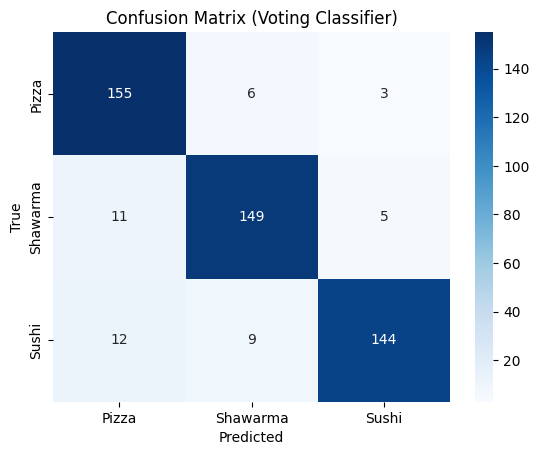

In [12]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# 1. Load Data
df = pd.read_csv("/content/drive/MyDrive/cleaned_data_bow.csv")
df = df.dropna(subset=["Label"])

# 2. Separate Features and Labels
X = df.drop(columns=["Label"])
y = df["Label"]

# 3. Identify Numeric and Text Columns
numeric_columns = [col for col in X.columns if X[col].dtype in ["int64", "float64"]]
bow_columns = [col for col in X.columns if col not in numeric_columns]

# 4. Apply TF-IDF Transformation
def tfidf_transform(df_bow):
    N = df_bow.shape[0]
    df_counts = (df_bow > 0).sum(axis=0)
    idf = df_counts.apply(lambda df_val: math.log(N / (1 + df_val)))
    tfidf_matrix = df_bow.multiply(idf, axis=1)
    return tfidf_matrix

df_tfidf = tfidf_transform(X[bow_columns])

# 5. Normalize Numeric Features
if numeric_columns:
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(X[numeric_columns]), columns=numeric_columns, index=X.index)
    X_final = pd.concat([df_tfidf, df_scaled], axis=1)
else:
    X_final = df_tfidf

# 6. Feature Selection
k_best = SelectKBest(chi2, k=500)
X_final = k_best.fit_transform(X_final, y)

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42, stratify=y)

# 8. Grid Search for Naive Bayes
param_grid_nb = {'alpha': np.linspace(0.1, 1.0, 10)}
grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, scoring="accuracy")
grid_search_nb.fit(X_train, y_train)
best_nb_model = grid_search_nb.best_estimator_
print("Best Naive Bayes alpha:", grid_search_nb.best_params_)

# 9. Train Random Forest (no grid search)
from sklearn.ensemble import RandomForestClassifier
best_rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=2, max_depth=None, random_state=42)
best_rf_model.fit(X_train, y_train)

# 10. Grid Search for Custom Logistic Regression
best_lr_model = None
best_score = 0
best_params = {}

lr_grid = {
    "lr": [0.01, 0.05, 0.1],
    "epochs": [1000, 2000, 4000],
    "reg_strength": [0.01, 0.1, 0.5]
}

for lr in lr_grid["lr"]:
    for epochs in lr_grid["epochs"]:
        for reg in lr_grid["reg_strength"]:
            print(f"Training Logistic Regression: lr={lr}, epochs={epochs}, reg={reg}")
            model = CustomMulticlassLogisticRegression(lr=lr, epochs=epochs, reg_strength=reg)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            if acc > best_score:
                best_score = acc
                best_lr_model = model
                best_params = {"lr": lr, "epochs": epochs, "reg_strength": reg}

print(f"Best Logistic Regression Params: {best_params}")

# 11. Evaluation
print("\nNaive Bayes Accuracy:", accuracy_score(y_test, best_nb_model.predict(X_test)))
print(classification_report(y_test, best_nb_model.predict(X_test)))

print("\nRandom Forest Accuracy:", accuracy_score(y_test, best_rf_model.predict(X_test)))
print(classification_report(y_test, best_rf_model.predict(X_test)))

lr_preds = best_lr_model.predict(X_test)
print("\nLogistic Regression Accuracy:", accuracy_score(y_test, lr_preds))
print(classification_report(y_test, lr_preds))

# 12. Custom Voting Classifier
from scipy.stats import mode

def custom_voting_classifier(X):
    pred_nb = best_nb_model.predict(X)
    pred_rf = best_rf_model.predict(X)
    pred_lr = best_lr_model.predict(X)
    all_preds = np.vstack([pred_nb, pred_rf, pred_lr]).T
    final_preds = []
    for row in all_preds:
        values, counts = np.unique(row, return_counts=True)
        final_preds.append(values[np.argmax(counts)])
    return np.array(final_preds)

# 13. Make Predictions
y_train_pred = custom_voting_classifier(X_train)
y_test_pred = custom_voting_classifier(X_test)

# 14. Evaluate Performance
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTraining Accuracy (Voting): {train_accuracy:.4f}")
print(f"Testing Accuracy (Voting): {test_accuracy:.4f}")
print("\nClassification Report (Test Set - Voting):")
print(classification_report(y_test, y_test_pred))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred, labels=["Pizza", "Shawarma", "Sushi"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pizza", "Shawarma", "Sushi"],
            yticklabels=["Pizza", "Shawarma", "Sushi"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Voting Classifier)")
plt.show()
